<a href="https://colab.research.google.com/github/keishagupta/COLORAID/blob/main/COLOR_AID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision torchaudio
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import cv2
import numpy as np
import torch
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [ ]:
# Dictionary of color blindness simulation matrices
COLOR_BLINDNESS_MATRICES = {
    "normal": np.array([[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]),
    "protanopia": np.array([[0.567, 0.433, 0.0], [0.558, 0.442, 0.0], [0.0, 0.242, 0.758]]),
    "protanomaly": np.array([[0.817, 0.183, 0.0], [0.333, 0.667, 0.0], [0.0, 0.125, 0.875]]),
    "deuteranopia": np.array([[0.625, 0.375, 0.0], [0.7, 0.3, 0.0], [0.0, 0.3, 0.7]]),
    "deuteranomaly": np.array([[0.8, 0.2, 0.0], [0.258, 0.742, 0.0], [0.0, 0.142, 0.858]]),
    "tritanopia": np.array([[0.95, 0.05, 0.0], [0.0, 0.433, 0.567], [0.0, 0.475, 0.525]]),
    "tritanomaly": np.array([[0.967, 0.033, 0.0], [0.0, 0.733, 0.267], [0.0, 0.183, 0.817]]),
    "achromatopsia": np.array([[0.299, 0.587, 0.114], [0.299, 0.587, 0.114], [0.299, 0.587, 0.114]]),
    "achromatomaly": np.array([[0.618, 0.320, 0.062], [0.163, 0.775, 0.062], [0.163, 0.320, 0.516]])
}

In [ ]:
def simulate_color_blindness(image_path, deficiency_type):
    """Simulate color blindness by applying a transformation matrix."""
    if deficiency_type not in COLOR_BLINDNESS_MATRICES:
        raise ValueError(f"Invalid deficiency type. Choose from {list(COLOR_BLINDNESS_MATRICES.keys())}.")

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    normalized_image = image / 255.0
    transform_matrix = COLOR_BLINDNESS_MATRICES[deficiency_type]
    transformed_image = np.dot(normalized_image.reshape(-1, 3), transform_matrix.T)
    transformed_image = np.clip(transformed_image, 0, 1).reshape(image.shape)
    transformed_image = (transformed_image * 255).astype(np.uint8)

    # Display the simulated image
    plt.imshow(transformed_image)
    plt.title(f"Simulated: {deficiency_type}")
    plt.axis("off")
    plt.show()

    return transformed_image

In [ ]:
def setup_detectron2_model():
    """Set up the Detectron2 configuration and predictor."""
    cfg = get_cfg()
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    return DefaultPredictor(cfg), cfg

def detect_objects(image, predictor, cfg):
    """Detect objects using Detectron2 and return details."""
    outputs = predictor(image)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy()
    scores = instances.scores.numpy()
    class_ids = instances.pred_classes.numpy()

    # Get class names from metadata
    metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
    class_names = metadata.thing_classes

    # Visualize and display the detection output
    v = Visualizer(image[:, :, ::-1], metadata=metadata, scale=1.2)
    vis_output = v.draw_instance_predictions(instances)
    vis_image = vis_output.get_image()[:, :, ::-1]  # Convert BGR to RGB for matplotlib

    plt.figure(figsize=(12, 8))
    plt.imshow(vis_image)
    plt.title("Detected Objects (with Bounding Boxes)")
    plt.axis("off")
    plt.show()

    # Format output
    detected_objects = []
    masks = instances.pred_masks.numpy() if instances.has("pred_masks") else None

    for i in range(len(boxes)):
        class_name = class_names[class_ids[i]] if class_ids[i] < len(class_names) else "Unknown"
        bbox_data = {
            "class": class_name,
            "confidence": float(scores[i]),
            "bounding_box": {
                "x1": float(boxes[i][0]),
                "y1": float(boxes[i][1]),
                "x2": float(boxes[i][2]),
                "y2": float(boxes[i][3]),
            }
        }

        if masks is not None:
            mask = (masks[i] * 255).astype(np.uint8)
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            bbox_data["edges"] = [contour.reshape(-1, 2).tolist() for contour in contours]

        detected_objects.append(bbox_data)

    return detected_objects

def save_detected_objects_with_edges(image, detected_objects, output_path):
    """Save detected objects with edges to a JSON file."""
    edge_data = [obj for obj in detected_objects if "edges" in obj]
    with open(output_path, "w") as f:
        json.dump(edge_data, f, indent=2)

In [ ]:
def analyze_iou_and_lab_similarity(image_bgr, json_path, color_threshold=20.0, iou_threshold=0):
    """Analyze detected objects based on IoU and LAB color similarity."""
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    height, width = image_rgb.shape[:2]

    with open(json_path, "r") as f:
        objects = json.load(f)

    # Convert contour edges to mask
    def contour_to_mask(edges):
        mask = np.zeros((height, width), dtype=np.uint8)
        for edge in edges:
            contour = np.array(edge, dtype=np.int32).reshape((-1, 1, 2))
            cv2.drawContours(mask, [contour], -1, 255, thickness=cv2.FILLED)
        return mask

    # Get average LAB color for the mask
    def get_avg_lab(mask, image_rgb):
        masked_pixels = image_rgb[mask == 255]
        if masked_pixels.size == 0:
            return np.zeros(3)
        lab = rgb2lab(masked_pixels.reshape(-1, 1, 3) / 255.0).reshape(-1, 3)
        return np.mean(lab, axis=0)

    # Compute Intersection over Union (IoU)
    def compute_iou(mask1, mask2):
        inter = np.logical_and(mask1 == 255, mask2 == 255).sum()
        union = np.logical_or(mask1 == 255, mask2 == 255).sum()
        return inter / union if union > 0 else 0

    # Prepare masks and LAB values for each object
    masks = [contour_to_mask(obj["edges"]) for obj in objects]
    lab_means = [get_avg_lab(mask, image_rgb) for mask in masks]

    # Compare all pairs based on IoU and LAB color similarity
    similar_pairs = []
    for i in range(len(objects)):
        for j in range(i + 1, len(objects)):
            iou = compute_iou(masks[i], masks[j])
            if iou >= iou_threshold:
                deltaE = np.linalg.norm(lab_means[i] - lab_means[j])
                if deltaE < color_threshold:
                    similar_pairs.append({
                        "obj1_index": i,
                        "obj2_index": j,
                        "label1": objects[i]["class"],
                        "label2": objects[j]["class"],
                        "iou": float(iou),
                        "deltaE": float(deltaE)
                    })
                    print(f"[MATCH] {objects[i]['class']} vs {objects[j]['class']} | IoU={iou:.2f} | ΔE={deltaE:.2f}")

    # Highlight edges of similar objects
    highlighted = image_rgb.copy()
    for pair in similar_pairs:
        for obj_id in [pair["obj1_index"], pair["obj2_index"]]:
            contours = [np.array(edge, np.int32).reshape((-1, 1, 2)) for edge in objects[obj_id]["edges"]]
            cv2.drawContours(highlighted, contours, -1, (0, 255, 0), thickness=3)

    # Visualize highlighted image
    plt.figure(figsize=(10, 10))
    plt.imshow(highlighted)
    plt.axis("off")
    plt.title(f"Similar Object Pairs (IoU ≥ {iou_threshold}, ΔE < {color_threshold})")
    plt.show()

    # Save output image and JSON with similar pairs
    output_image_path = "/content/edges_highlighted.jpg"
    output_json_path = "/content/similar_pairs_report.json"
    cv2.imwrite(output_image_path, cv2.cvtColor(highlighted, cv2.COLOR_RGB2BGR))

    with open(output_json_path, "w") as f:
        json.dump(similar_pairs, f, indent=2)

    print(f"Done. Found {len(similar_pairs)} pairs. Output saved to {output_image_path} and {output_json_path}.")

    return similar_pairs

def adjust_similar_object_colors(lab_image, masks, similar_pairs, color_shift=60, shift_mode='auto', output_preview_path=None):
    """Shifts the LAB color of one object in each similar-colored object pair."""
    adjusted_image = lab_image.copy()
    adjusted_ids = set()

    for pair in similar_pairs:
        target_id = pair["obj2_index"]
        if target_id in adjusted_ids:
            continue  # Skip if already adjusted

        mask = masks[target_id]
        object_pixels = adjusted_image[mask == 255]

        if object_pixels.size == 0:
            continue  # Skip empty masks

        # Compute mean LAB color
        mean_color = np.mean(object_pixels, axis=0)

        # Determine shift direction
        if shift_mode == 'a':
            shift = np.array([0, color_shift, 0])
        elif shift_mode == 'b':
            shift = np.array([0, 0, color_shift])
        else:  # auto
            shift = np.array([0, 0, 0])
            if abs(mean_color[1]) < abs(mean_color[2]):
                shift[1] = color_shift  # a channel
            else:
                shift[2] = color_shift  # b channel

        # Apply shift
        for i in range(3):
            channel = adjusted_image[:, :, i]
            channel[mask == 255] = np.clip(channel[mask == 255] + shift[i], 0, 255)
            adjusted_image[:, :, i] = channel

        adjusted_ids.add(target_id)
        print(f"[INFO] Shifted color of object {target_id} by {shift} in LAB space.")

    # Optional preview save
    if output_preview_path:
        rgb_preview = (lab2rgb(adjusted_image) * 255).astype(np.uint8)
        cv2.imwrite(output_preview_path, cv2.cvtColor(rgb_preview, cv2.COLOR_RGB2BGR))
        print(f"[INFO] Saved preview image to '{output_preview_path}'")

    return adjusted_image

In [ ]:
def simulate_color_blindness_on_region(rgb_image, deficiency_type, region_mask):
    """Applies color blindness simulation only on a masked region of the image."""
    if deficiency_type not in COLOR_BLINDNESS_MATRICES:
        raise ValueError(f"Invalid deficiency type. Choose from {list(COLOR_BLINDNESS_MATRICES.keys())}.")

    transformed_image = rgb_image.copy().astype(np.float32) / 255.0
    mask_indices = np.where(region_mask == 255)

    # Extract only the masked pixels
    pixels = transformed_image[mask_indices]
    transformed_pixels = np.dot(pixels, COLOR_BLINDNESS_MATRICES[deficiency_type].T)
    transformed_pixels = np.clip(transformed_pixels, 0, 1)

    # Update only masked region in the image
    transformed_image[mask_indices] = transformed_pixels
    transformed_image = (transformed_image * 255).astype(np.uint8)

    return transformed_image

In [ ]:
def simulate_and_process(image_path, output_path):
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found at {image_path}")

    predictor, cfg = setup_detectron2_model()
    detected_objects = detect_objects(image, predictor, cfg)
    save_detected_objects_with_edges(image, detected_objects, "/content/detected_objects_with_edges.json")

    deficiency_type = "protanopia"
    transformed_image = simulate_color_blindness(image_path, deficiency_type)
    transformed_bgr = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)

    iteration = 0
    max_iterations = 10
    previous_lab = rgb2lab(transformed_image / 255.0)

    while iteration < max_iterations:
        print(f"\n--- Iteration {iteration + 1} ---")

        similar_pairs = analyze_iou_and_lab_similarity(
            transformed_bgr,
            "/content/detected_objects_with_edges.json",
            color_threshold=20.0,
            iou_threshold=0
        )

        if not similar_pairs:
            print("No similar object pairs found. Stopping adjustment.")
            break

        print(f"Found {len(similar_pairs)} similar object pairs. Adjusting colors...")

        with open("/content/detected_objects_with_edges.json", 'r') as f:
            objects_with_edges = json.load(f)

        masks = []
        height, width = transformed_image.shape[:2]
        for obj in objects_with_edges:
            mask = np.zeros((height, width), dtype=np.uint8)
            for contour in obj.get("edges", []):
                contour_np = np.array(contour, dtype=np.int32).reshape((-1, 1, 2))
                cv2.drawContours(mask, [contour_np], -1, 255, -1)
            masks.append(mask)

        current_lab = rgb2lab(transformed_image / 255.0)

        adjusted_lab = adjust_similar_object_colors(
            lab_image=current_lab.copy(),
            masks=masks,
            similar_pairs=similar_pairs,
            color_shift=50,
            shift_mode='b',
            output_preview_path=f"/content/lab_adjusted_preview_iter{iteration + 1}.jpg"
        )

        if np.allclose(adjusted_lab, previous_lab, atol=1e-3):
            print("No significant LAB change detected. Stopping.")
            break

        previous_lab = adjusted_lab.copy()

        adjusted_rgb = (lab2rgb(adjusted_lab) * 255).astype(np.uint8)

        adjusted_mask = np.zeros((height, width), dtype=np.uint8)
        for pair in similar_pairs:
            adjusted_mask = cv2.bitwise_or(adjusted_mask, masks[pair["obj2_index"]])

        transformed_image = simulate_color_blindness_on_region(adjusted_rgb, deficiency_type, adjusted_mask)
        transformed_bgr = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)

        iter_path = f"/content/final_iter_{iteration + 1}_simulated.jpg"
        cv2.imwrite(iter_path, transformed_bgr)
        print(f"Saved simulated result after iteration {iteration + 1} to {iter_path}")

        iteration += 1

    # Use the provided output_path here
    cv2.imwrite(output_path, transformed_bgr)
    print(f"\nFinal simulated image with all adjustments saved to {output_path}")

    plt.figure(figsize=(12, 12))
    plt.imshow(cv2.cvtColor(transformed_bgr, cv2.COLOR_BGR2RGB))
    plt.title("Final Adjusted Simulated Output")
    plt.axis("off")
    plt.show()


In [ ]:
!pip install flask pyngrok

In [ ]:
import os

UPLOAD_FOLDER = '/content/uploads'
OUTPUT_FOLDER = '/content/outputs'
STATIC_FOLDER = '/content/static'
TEMPLATES_FOLDER = '/content/templates'

# Create folders if they don't exist
os.makedirs(UPLOAD_FOLDER, exist_ok=True)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(STATIC_FOLDER, exist_ok=True)
os.makedirs(TEMPLATES_FOLDER, exist_ok=True)


In [ ]:
# Create home.html
home_html = '''
<!doctype html>
<title>Upload an Image</title>
<h1>Upload an Image for Processing</h1>
<form method=post enctype=multipart/form-data action="/upload">
  <input type=file name=file>
  <input type=submit value=Upload>
</form>
'''
with open(os.path.join(TEMPLATES_FOLDER, 'home.html'), 'w') as f:
    f.write(home_html)

# Create result.html
result_html = '''
<!doctype html>
<title>Result</title>
<h1>Processed Image</h1>
<img src="{{ url_for('static', filename='processed_output.jpg') }}" width="500">
<br><br>
<a href="/">Upload Another Image</a>
'''
with open(os.path.join(TEMPLATES_FOLDER, 'result.html'), 'w') as f:
    f.write(result_html)


In [ ]:
!ngrok config add-authtoken 2wMebHlL76WAHPQjk08UMsf31hC_5wTZYzEuiRzND1dDfDtsR

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


 * Public URL: NgrokTunnel: "https://ed99-34-106-197-187.ngrok-free.app" -> "http://localhost:5000"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [28/Apr/2025 16:08:17] "GET / HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Apr/2025 16:08:17] "GET /favicon.ico HTTP/1.1" 404 -


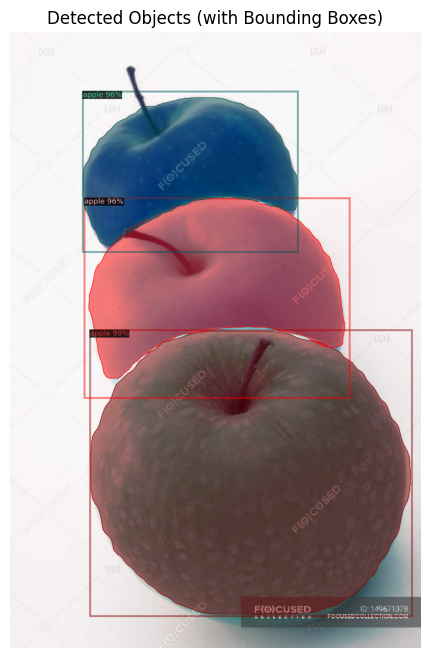

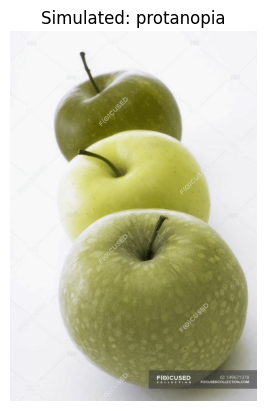


--- Iteration 1 ---
[MATCH] apple vs apple | IoU=0.00 | ΔE=8.03


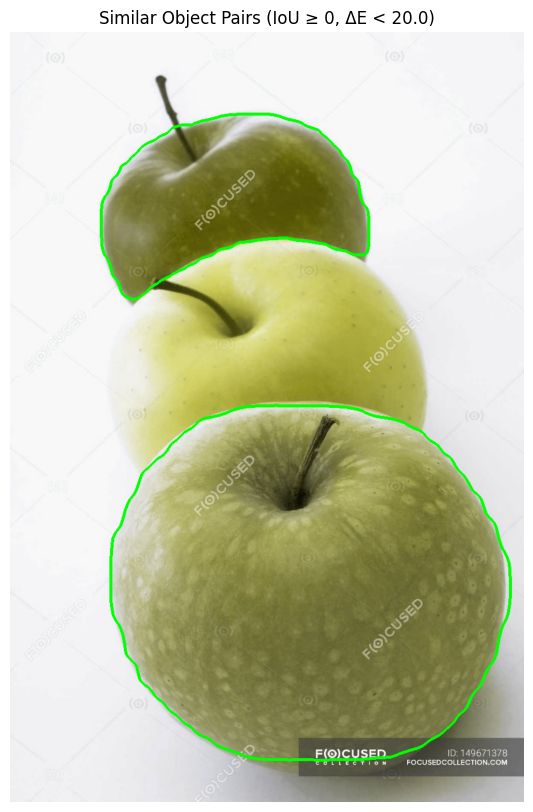

Done. Found 1 pairs. Output saved to /content/edges_highlighted.jpg and /content/similar_pairs_report.json.
Found 1 similar object pairs. Adjusting colors...
[INFO] Shifted color of object 1 by [ 0  0 50] in LAB space.


<ipython-input-6-72a6f644978b>:121: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 11607 negative Z values that have been clipped to zero
  rgb_preview = (lab2rgb(adjusted_image) * 255).astype(np.uint8)


[INFO] Saved preview image to '/content/lab_adjusted_preview_iter1.jpg'


<ipython-input-19-8580f32d8f12>:63: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 11607 negative Z values that have been clipped to zero
  adjusted_rgb = (lab2rgb(adjusted_lab) * 255).astype(np.uint8)


Saved simulated result after iteration 1 to /content/final_iter_1_simulated.jpg

--- Iteration 2 ---


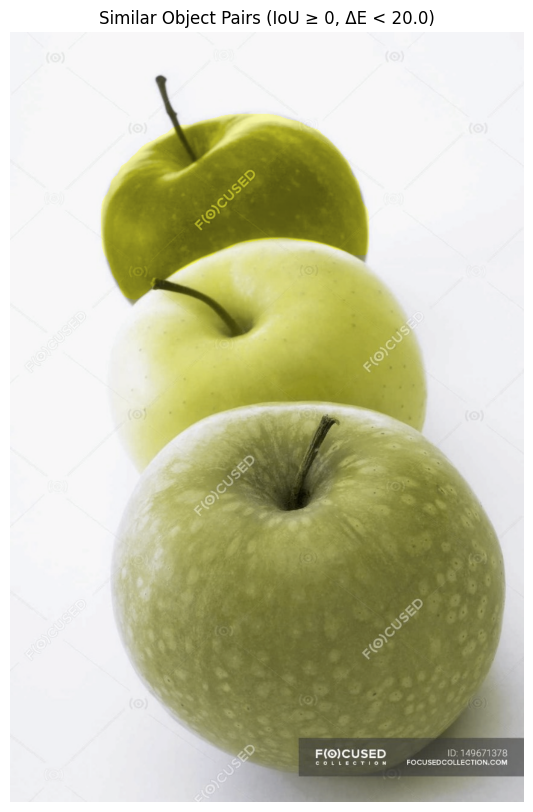

Done. Found 0 pairs. Output saved to /content/edges_highlighted.jpg and /content/similar_pairs_report.json.
No similar object pairs found. Stopping adjustment.

Final simulated image with all adjustments saved to /content/outputs/processed_output.jpg


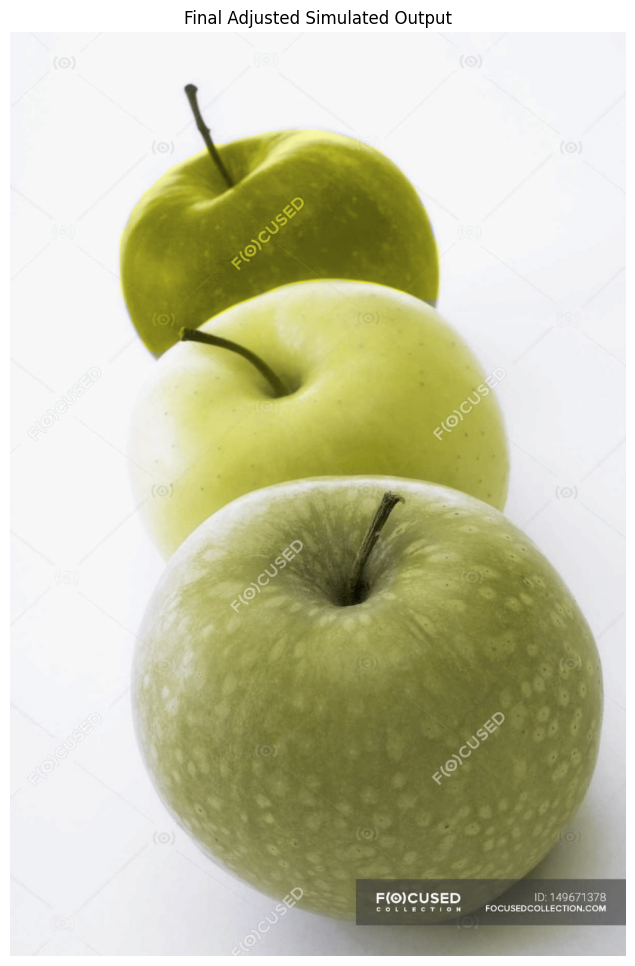

INFO:werkzeug:127.0.0.1 - - [28/Apr/2025 16:08:38] "POST /upload HTTP/1.1" 302 -
INFO:werkzeug:127.0.0.1 - - [28/Apr/2025 16:08:38] "GET /result HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [28/Apr/2025 16:08:39] "GET /static/processed_output.jpg HTTP/1.1" 200 -


In [ ]:
from flask import Flask, request, redirect, render_template
from pyngrok import ngrok
import shutil

app = Flask(__name__, template_folder=TEMPLATES_FOLDER)
app.config['UPLOAD_FOLDER'] = UPLOAD_FOLDER
app.config['OUTPUT_FOLDER'] = OUTPUT_FOLDER
app.config['STATIC_FOLDER'] = STATIC_FOLDER

@app.route('/')
def index():
    return render_template('home.html')

@app.route('/upload', methods=['POST'])
def upload_file():
    if 'file' not in request.files:
        return 'No file part'
    file = request.files['file']
    if file.filename == '':
        return 'No selected file'

    # Save uploaded file
    filepath = os.path.join(app.config['UPLOAD_FOLDER'], file.filename)
    file.save(filepath)

    # 🔥 Define output path now
    output_path = os.path.join(app.config['OUTPUT_FOLDER'], 'processed_output.jpg')

    # 🔥 CALL your existing processing function here
    # Example function call
    simulate_and_process(filepath, output_path)

    # 🔥 Now copy the processed file to static folder for display
    shutil.copy(output_path, os.path.join(app.config['STATIC_FOLDER'], 'processed_output.jpg'))

    return redirect('/result')

@app.route('/result')
def result():
    return render_template('result.html')

# Setup public URL
public_url = ngrok.connect(5000)
print(" * Public URL:", public_url)

app.run(port=5000)